In [1]:
import matplotlib.pyplot as plt

### Implementation Notes

##### APriori Algorithm: 

We take in a collection of transactions and a minimum frequency, and produce a set of frequent itemsets by the following procedure:

```
k = 1
Fk = frequent items
while Fk is not empty:
    Ck+1 = itemsets produced by combining items in Fk
    Fk+1 = itemsets of Ck+1 which are actually frequent
    k += 1
    set Fk = Fk+1
return set every element which has been a member of Fk
```

A given candidate itemset in Ck+1 is generated as the union of two itemsets in Fk which share their first k - 1 elements. Since are maintaining ordering of elements, this ensures that we avoid duplicate candidates. 

In my implementation, I stored the set of transactions as a list of integer hash tables, and the itemsets as arrays. This allows checking an item's membership in a transaction in O(1) time, so checking for an itemset is O(|itemset|)


##### Stage 1: transactions to possible frequent itemsets 

In this stage, each mapper computes the frequent items from its portion of transactions using the APriori algorithm. The reducer does not modify anything, so the output from the first phase is a collection of itemsets C in the form (C,1). 

##### Stage 2: candidate itemsets to frequent itemsets

We now compute the support for each itemset and determine whether it is frequent. Each mapper uses the output from the previous stage and operates on a portion of transactions (or one transaction, for the single version), and then the reducers calculate supports from their output. 

For the multi version, I implemented this where mappers iterate over transactions, and emit (F,1) whenever an itemset F is present within a transaction. In the single version, mappers emit (F,1) for each itemset F which is present within the their assigned transaction. Their output goes to combiners before being passed to the reduce phase to minimize the volume of messages. 

### Results

In [63]:
# data
transactions_per_block = [7360, 14520, 21680, 28840, 36000]

single_runtimes = [5675723, 3051653, 2601094, 1524106, 1168769] 
single_minutes = [x / 60000 for x in single_runtimes]
single_rone = [28882, 18198, 13823, 8715, 6214]
single_rtwo = [2679, 2679, 2679, 2679, 2679]

multi_runtimes = [5351482, 3191195, 2520443, 1680560, 1590547]
multi_minutes = [x / 60000 for x in multi_runtimes]
multi_rone = [28882, 18198, 13823, 8715, 6214]
multi_rtwo = [2679, 2679, 2679, 2679, 2679]

##### Runtime vs. Transactions per Block

Text(0, 0.5, 'Runtime (ms)')

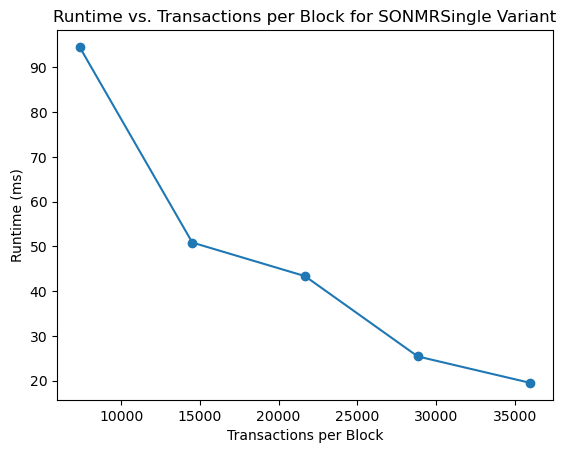

In [73]:
# runtime vs. transactions_per_block (single)
plt.plot(transactions_per_block, single_minutes)
plt.scatter(transactions_per_block, single_minutes)
plt.title("Runtime vs. Transactions per Block for SONMRSingle Variant")
plt.xlabel("Transactions per Block")
plt.ylabel("Runtime (ms)")

Text(0, 0.5, 'Runtime (ms)')

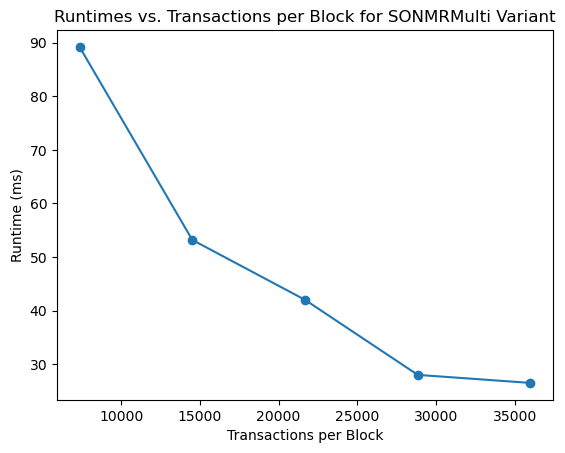

In [74]:
# runtime vs. transactions_per_block (multi)
plt.plot(transactions_per_block, multi_minutes)
plt.scatter(transactions_per_block, multi_minutes)
plt.title("Runtimes vs. Transactions per Block for SONMRMulti Variant")
plt.xlabel("Transactions per Block")
plt.ylabel("Runtime (ms)")

For both single and multi variants, we see a clear and significant decrease in runtime as transactions per block increases. This is likely due to the increase in candidate itemsets which require a pass over the dataset to verify, a hypothesis which is supported by how closely this curve aligns with the curve showing the relationship between itemsets in stage one output vs. transactions per block. Something that I find interesting is that for all points except the smallest value for transactions per block, the single variant outperforms the multi variant. However, for 7360 transactions per block, runtime spikes for the single variant. I'm curious if this would happen consistently, or if there is a certain threshold where the single implementation becomes much more inefficient--probably where the overhead from coordinating extra mappers overshadows the benefit. 

##### Number of Itemsets vs. Transactions per Block

Text(0, 0.5, 'Number of Itemsets')

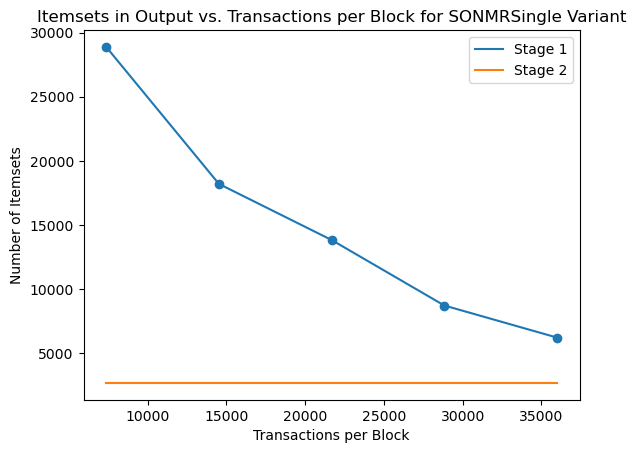

In [79]:
# number of itemsets vs. transactions_per_block (single)
plt.plot(transactions_per_block, single_rone, label="Stage 1")
plt.scatter(transactions_per_block, single_rone)
plt.plot(transactions_per_block, single_rtwo, label="Stage 2")
plt.legend()
plt.title("Itemsets in Output vs. Transactions per Block for SONMRSingle Variant")
plt.xlabel("Transactions per Block")
plt.ylabel("Number of Itemsets")

Text(0, 0.5, 'Number of Itemsets')

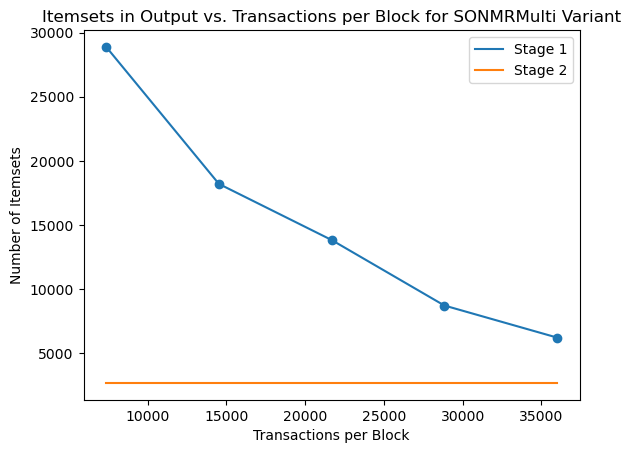

In [80]:
# number of itemsets vs. transactions_per_block (multi)
plt.plot(transactions_per_block, multi_rone, label="Stage 1")
plt.scatter(transactions_per_block, multi_rone)
plt.plot(transactions_per_block, multi_rtwo, label="Stage 2")
plt.legend()
plt.title("Itemsets in Output vs. Transactions per Block for SONMRMulti Variant")
plt.xlabel("Transactions per Block")
plt.ylabel("Number of Itemsets")

These plots are exactly the same. Stage 2 is constant, which needs to be the case--the same itemsets will be frequent regardless of how they are computed. The blue curve shows that the number of candidate itemsets from APriori increases for lower values of transactions per block, which occurs because a given itemset will have a higher frequency if calculated in a smaller sample. 